### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [5]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [7]:
train_images = glob.glob('/data/segmentation/segmentation/Kvasir-SEG/trainset/images/*')
train_labels = glob.glob('/data/segmentation/segmentation/Kvasir-SEG/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/segmentation/Kvasir-SEG/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/segmentation/Kvasir-SEG/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외


train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)


custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))


custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))


My custom training-dataset has 600 elements
My custom valing-dataset has 200 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

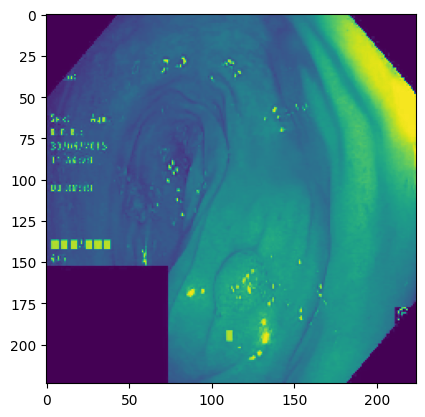

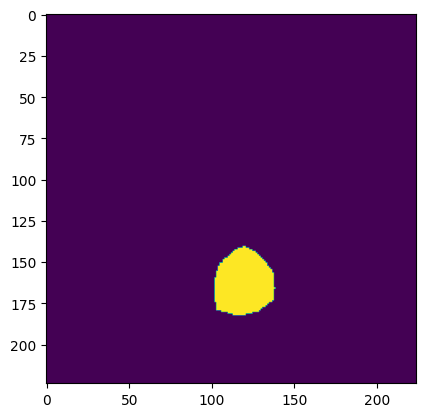

3픽셀의 평균값이라 색깔이 변경됨.


In [8]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [5]:
# Begin training
from models.pop_medical_seg_models.nnunet import Nested_UNet as UNet_2p

model = UNet_2p(1,3)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [10]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [11]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'UNet++'
data_name = 'Kvasir'

# 5. Training

 Epoch: 1 of 100, Iter.: 75 of 75, Train Loss: 1.212752, IoU: 0.322129, Dice: 0.449484
 Epoch: 1 of 100, Iter.: 75 of 75, Valid Loss: 1.116567, IoU: 0.408782, Dice: 0.543847

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


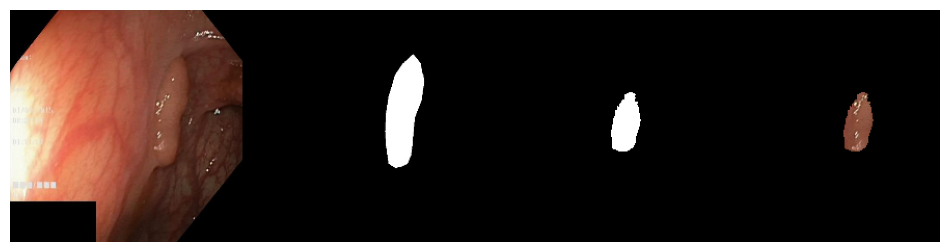

 Epoch: 2 of 100, Iter.: 75 of 75, Train Loss: 1.075038, IoU: 0.398521, Dice: 0.531000
 Epoch: 2 of 100, Iter.: 75 of 75, Valid Loss: 1.033463, IoU: 0.400152, Dice: 0.517122


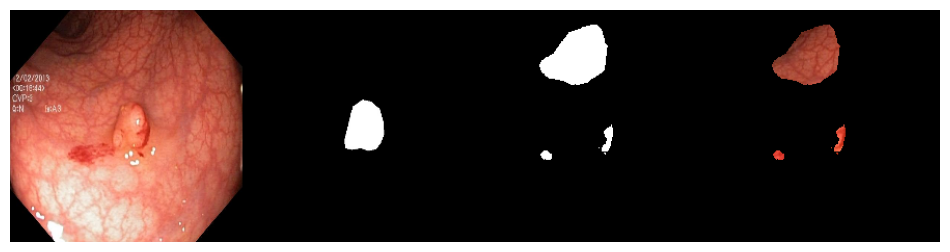

 Epoch: 3 of 100, Iter.: 75 of 75, Train Loss: 1.012551, IoU: 0.443010, Dice: 0.570059
 Epoch: 3 of 100, Iter.: 75 of 75, Valid Loss: 0.987301, IoU: 0.455144, Dice: 0.574638


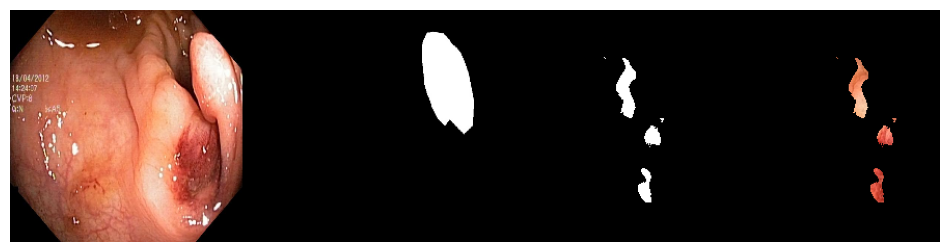

 Epoch: 4 of 100, Iter.: 75 of 75, Train Loss: 0.957640, IoU: 0.482507, Dice: 0.604912
 Epoch: 4 of 100, Iter.: 75 of 75, Valid Loss: 0.982798, IoU: 0.368833, Dice: 0.482469


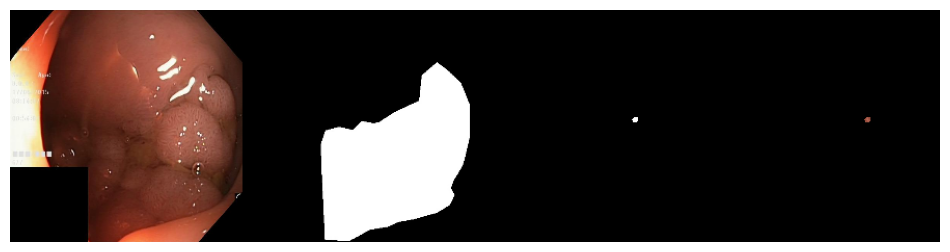

 Epoch: 5 of 100, Iter.: 75 of 75, Train Loss: 0.911792, IoU: 0.504635, Dice: 0.625323
 Epoch: 5 of 100, Iter.: 75 of 75, Valid Loss: 0.911137, IoU: 0.490045, Dice: 0.603483


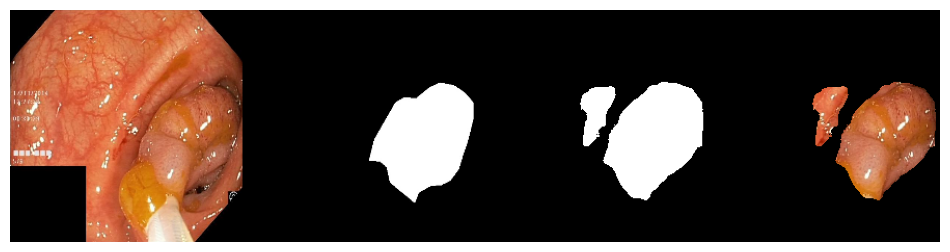

 Epoch: 6 of 100, Iter.: 75 of 75, Train Loss: 0.855066, IoU: 0.542778, Dice: 0.660765
 Epoch: 6 of 100, Iter.: 75 of 75, Valid Loss: 0.877506, IoU: 0.516706, Dice: 0.632248


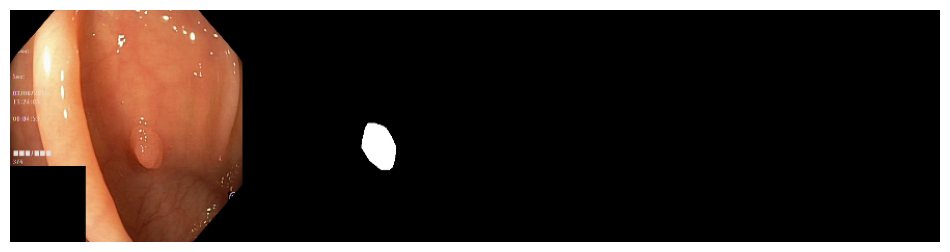

 Epoch: 7 of 100, Iter.: 75 of 75, Train Loss: 0.808761, IoU: 0.564091, Dice: 0.676408
 Epoch: 7 of 100, Iter.: 75 of 75, Valid Loss: 0.846553, IoU: 0.540498, Dice: 0.653501


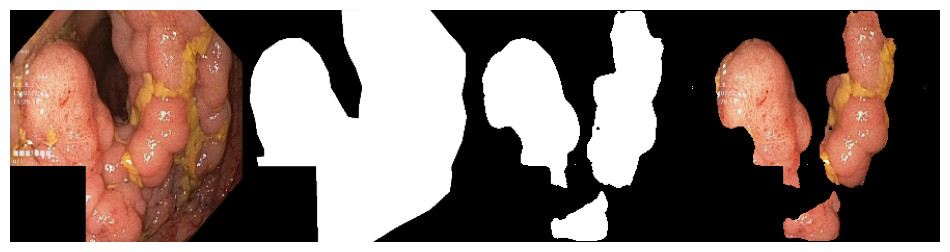

 Epoch: 8 of 100, Iter.: 75 of 75, Train Loss: 0.760183, IoU: 0.601569, Dice: 0.713652
 Epoch: 8 of 100, Iter.: 75 of 75, Valid Loss: 0.798059, IoU: 0.558248, Dice: 0.667080


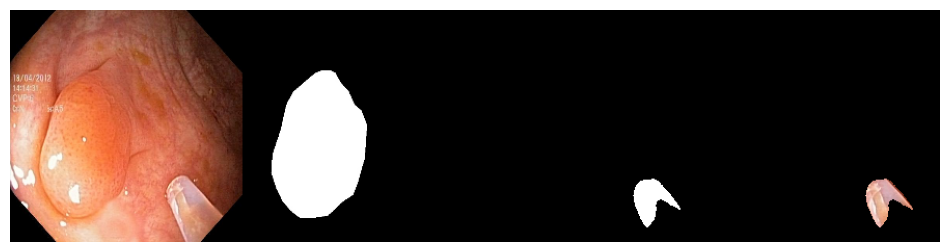

 Epoch: 9 of 100, Iter.: 75 of 75, Train Loss: 0.713125, IoU: 0.633114, Dice: 0.739665
 Epoch: 9 of 100, Iter.: 75 of 75, Valid Loss: 0.783492, IoU: 0.540121, Dice: 0.647172


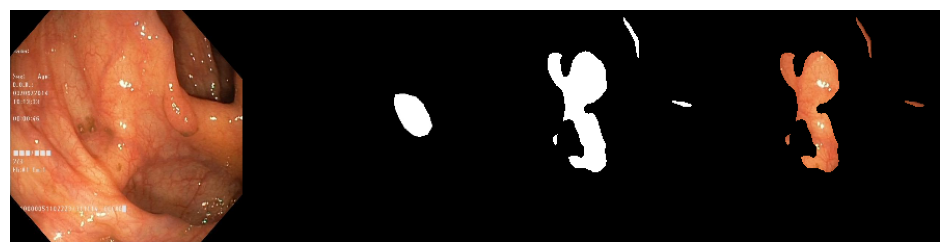

 Epoch: 10 of 100, Iter.: 75 of 75, Train Loss: 0.672616, IoU: 0.644444, Dice: 0.749227
 Epoch: 10 of 100, Iter.: 75 of 75, Valid Loss: 0.749668, IoU: 0.564346, Dice: 0.671037


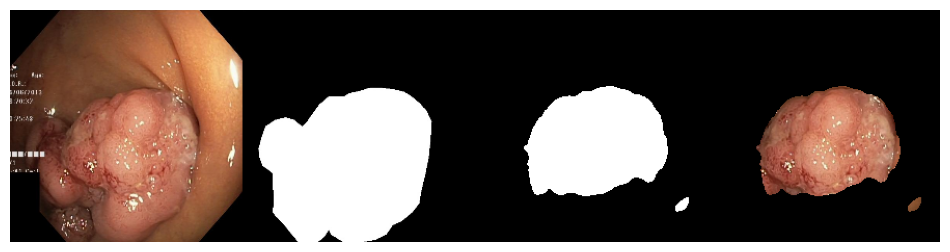

 Epoch: 11 of 100, Iter.: 75 of 75, Train Loss: 0.617792, IoU: 0.692467, Dice: 0.790655
 Epoch: 11 of 100, Iter.: 75 of 75, Valid Loss: 0.711352, IoU: 0.591230, Dice: 0.697886


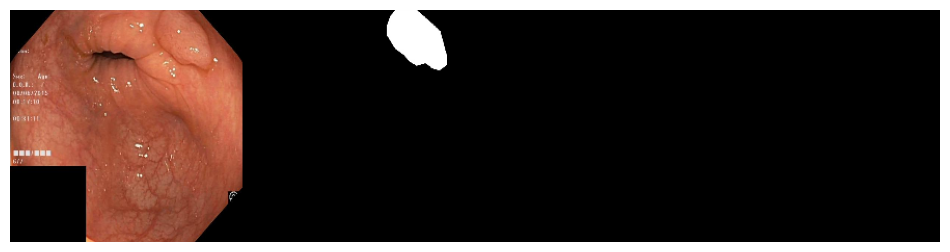

 Epoch: 12 of 100, Iter.: 75 of 75, Train Loss: 0.583904, IoU: 0.710123, Dice: 0.804260
 Epoch: 12 of 100, Iter.: 75 of 75, Valid Loss: 0.734508, IoU: 0.570995, Dice: 0.679749


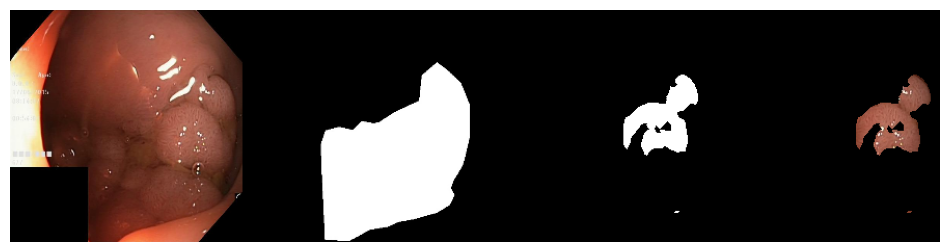

 Epoch: 13 of 100, Iter.: 75 of 75, Train Loss: 0.542440, IoU: 0.735916, Dice: 0.824141
 Epoch: 13 of 100, Iter.: 75 of 75, Valid Loss: 0.700065, IoU: 0.558650, Dice: 0.658006


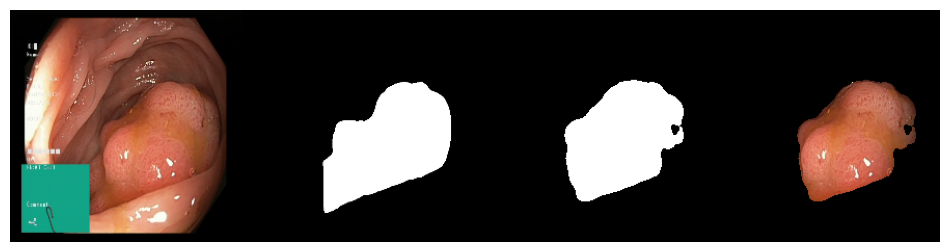

 Epoch: 14 of 100, Iter.: 75 of 75, Train Loss: 0.512272, IoU: 0.738732, Dice: 0.827228
 Epoch: 14 of 100, Iter.: 75 of 75, Valid Loss: 0.694373, IoU: 0.582924, Dice: 0.686902


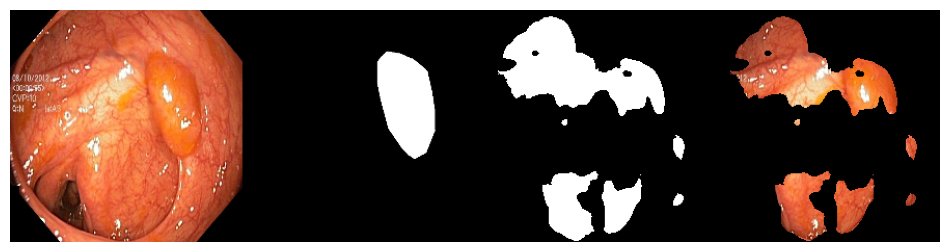

 Epoch: 15 of 100, Iter.: 75 of 75, Train Loss: 0.469009, IoU: 0.763384, Dice: 0.847300
 Epoch: 15 of 100, Iter.: 75 of 75, Valid Loss: 0.655934, IoU: 0.593917, Dice: 0.688107


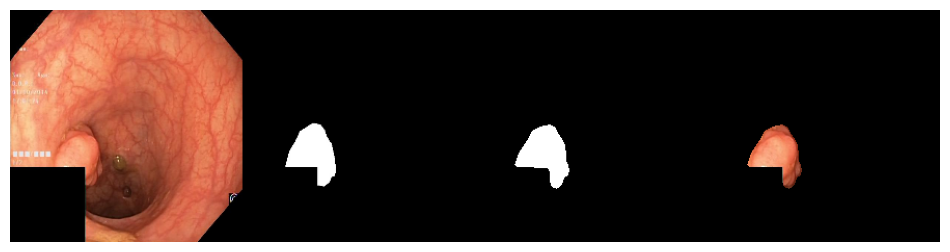

 Epoch: 16 of 100, Iter.: 75 of 75, Train Loss: 0.437121, IoU: 0.779651, Dice: 0.859469
 Epoch: 16 of 100, Iter.: 75 of 75, Valid Loss: 0.650004, IoU: 0.602071, Dice: 0.699204


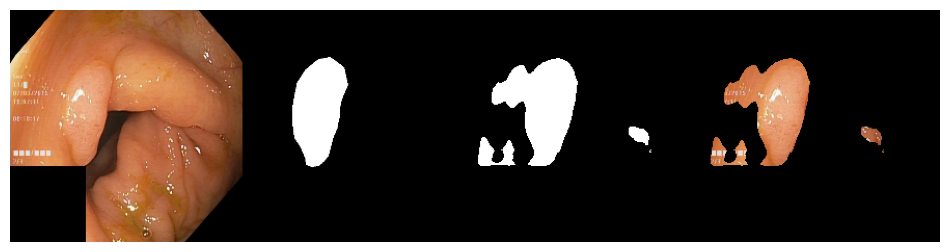

 Epoch: 17 of 100, Iter.: 75 of 75, Train Loss: 0.418861, IoU: 0.777422, Dice: 0.854709
 Epoch: 17 of 100, Iter.: 75 of 75, Valid Loss: 0.629105, IoU: 0.603462, Dice: 0.694985


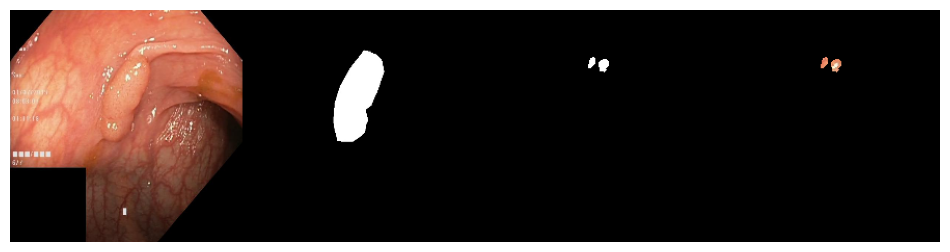

 Epoch: 18 of 100, Iter.: 75 of 75, Train Loss: 0.376601, IoU: 0.807527, Dice: 0.878992
 Epoch: 18 of 100, Iter.: 75 of 75, Valid Loss: 0.616917, IoU: 0.614523, Dice: 0.719040


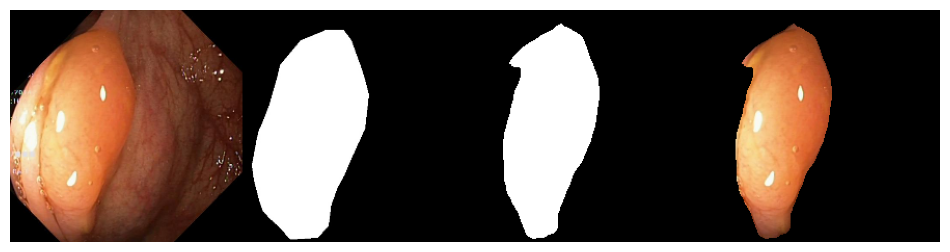

 Epoch: 19 of 100, Iter.: 75 of 75, Train Loss: 0.345787, IoU: 0.818388, Dice: 0.886259
 Epoch: 19 of 100, Iter.: 75 of 75, Valid Loss: 0.599316, IoU: 0.619879, Dice: 0.714702


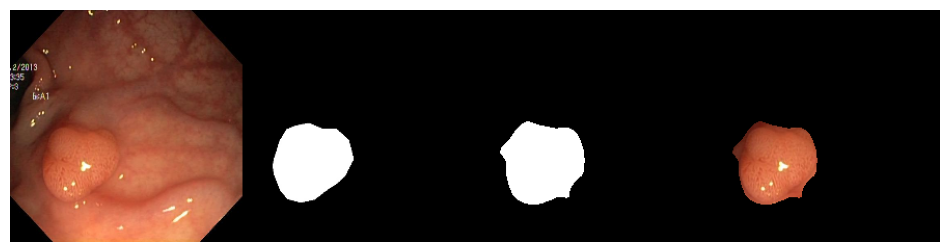

 Epoch: 20 of 100, Iter.: 75 of 75, Train Loss: 0.317665, IoU: 0.839727, Dice: 0.900770
 Epoch: 20 of 100, Iter.: 75 of 75, Valid Loss: 0.578151, IoU: 0.627767, Dice: 0.720283


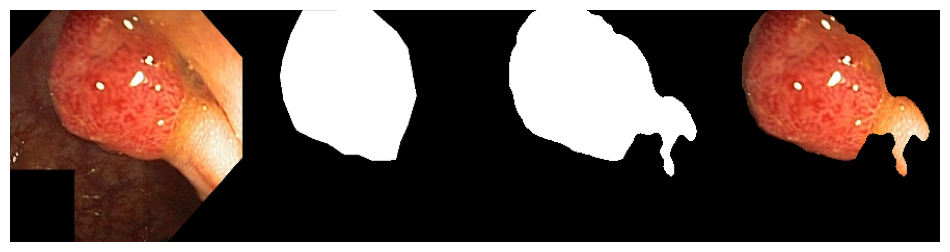

 Epoch: 21 of 100, Iter.: 75 of 75, Train Loss: 0.300060, IoU: 0.841121, Dice: 0.902751
 Epoch: 21 of 100, Iter.: 75 of 75, Valid Loss: 0.610077, IoU: 0.599739, Dice: 0.692759


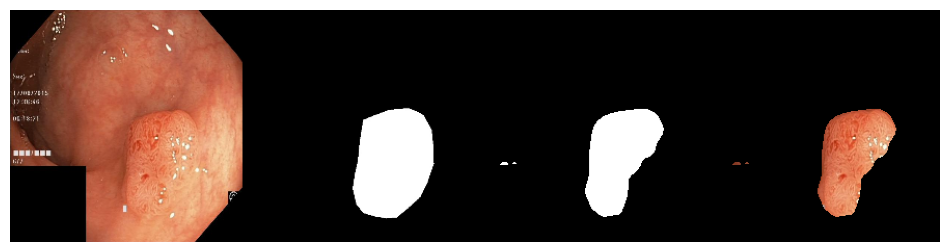

 Epoch: 22 of 100, Iter.: 75 of 75, Train Loss: 0.306722, IoU: 0.820933, Dice: 0.887266
 Epoch: 22 of 100, Iter.: 75 of 75, Valid Loss: 0.687716, IoU: 0.591236, Dice: 0.699401


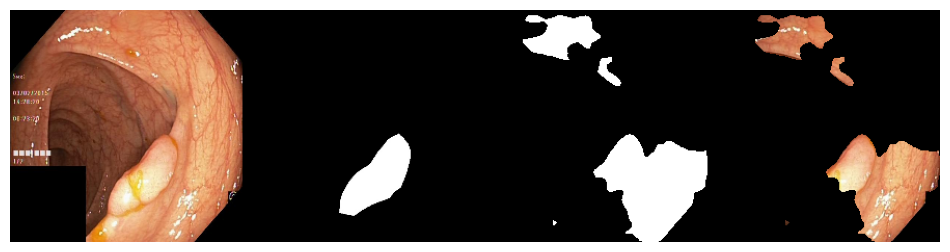

 Epoch: 23 of 100, Iter.: 75 of 75, Train Loss: 0.267629, IoU: 0.852657, Dice: 0.911779
 Epoch: 23 of 100, Iter.: 75 of 75, Valid Loss: 0.568600, IoU: 0.616833, Dice: 0.708110


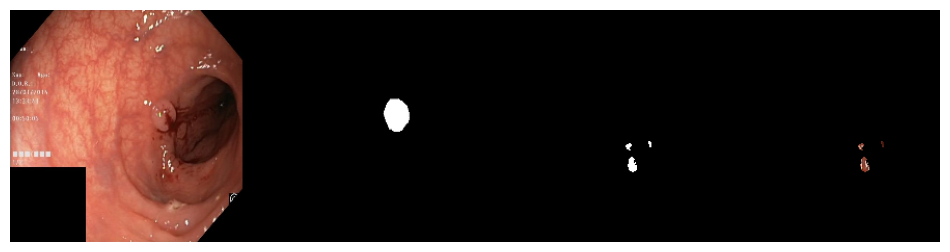

 Epoch: 24 of 100, Iter.: 75 of 75, Train Loss: 0.239780, IoU: 0.871511, Dice: 0.923502
 Epoch: 24 of 100, Iter.: 75 of 75, Valid Loss: 0.578433, IoU: 0.632549, Dice: 0.729998


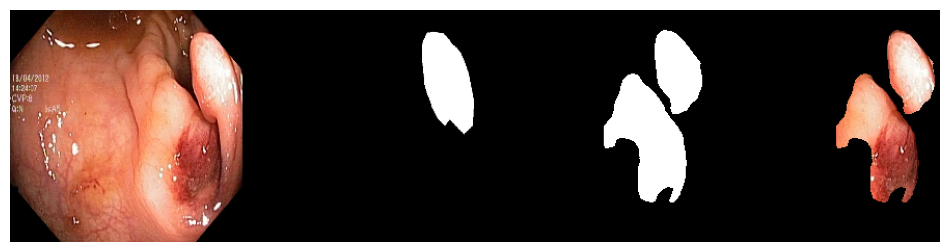

 Epoch: 25 of 100, Iter.: 75 of 75, Train Loss: 0.250095, IoU: 0.844712, Dice: 0.904856
 Epoch: 25 of 100, Iter.: 75 of 75, Valid Loss: 0.581150, IoU: 0.625987, Dice: 0.729881


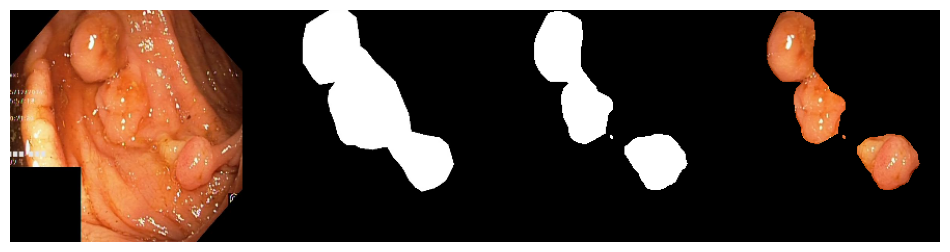

 Epoch: 26 of 100, Iter.: 75 of 75, Train Loss: 0.222704, IoU: 0.867514, Dice: 0.920427
 Epoch: 26 of 100, Iter.: 75 of 75, Valid Loss: 0.636493, IoU: 0.611467, Dice: 0.717898


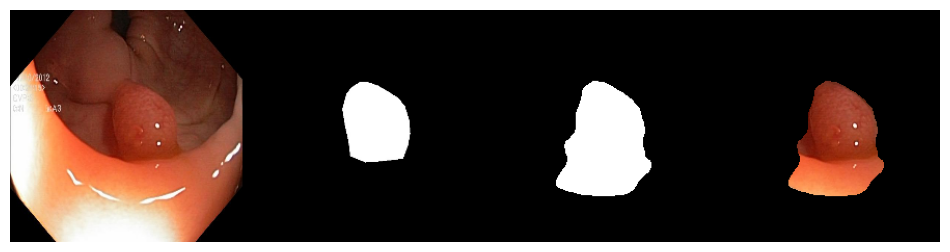

 Epoch: 27 of 100, Iter.: 75 of 75, Train Loss: 0.211419, IoU: 0.867986, Dice: 0.922000
 Epoch: 27 of 100, Iter.: 75 of 75, Valid Loss: 0.561580, IoU: 0.637886, Dice: 0.738080


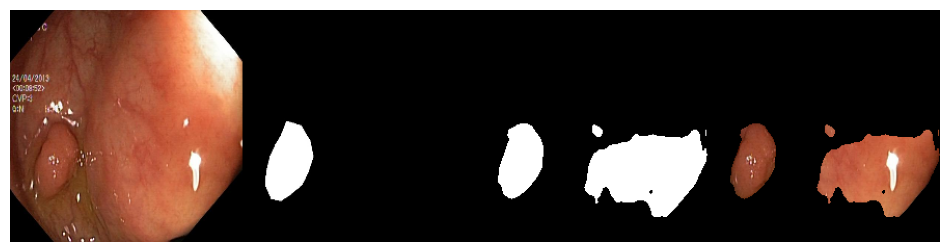

 Epoch: 28 of 100, Iter.: 75 of 75, Train Loss: 0.192099, IoU: 0.885558, Dice: 0.932827
 Epoch: 28 of 100, Iter.: 75 of 75, Valid Loss: 0.543014, IoU: 0.650664, Dice: 0.743024


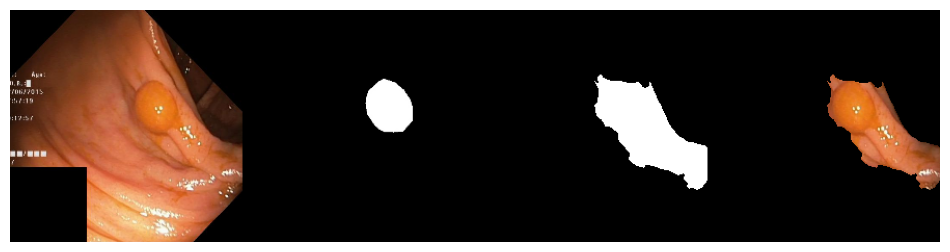

 Epoch: 29 of 100, Iter.: 75 of 75, Train Loss: 0.168111, IoU: 0.900067, Dice: 0.943411
 Epoch: 29 of 100, Iter.: 75 of 75, Valid Loss: 0.552055, IoU: 0.637254, Dice: 0.730526


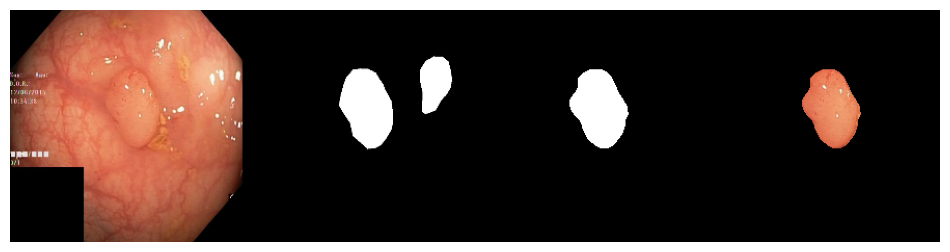

 Epoch: 30 of 100, Iter.: 75 of 75, Train Loss: 0.149391, IoU: 0.911678, Dice: 0.950127
 Epoch: 30 of 100, Iter.: 75 of 75, Valid Loss: 0.522370, IoU: 0.658807, Dice: 0.744848


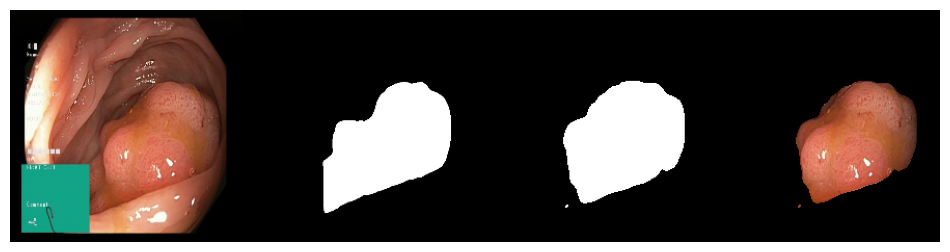

 Epoch: 31 of 100, Iter.: 75 of 75, Train Loss: 0.141815, IoU: 0.914975, Dice: 0.952517
 Epoch: 31 of 100, Iter.: 75 of 75, Valid Loss: 0.559737, IoU: 0.630586, Dice: 0.719903


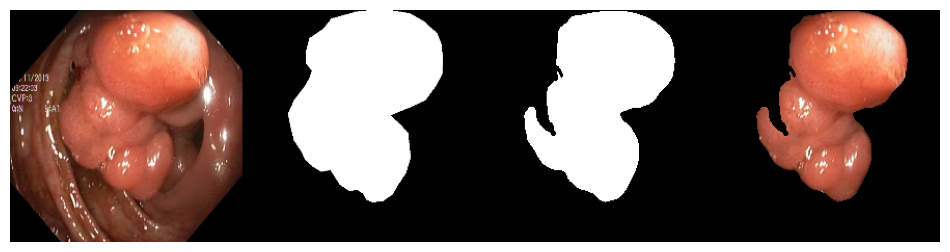

 Epoch: 32 of 100, Iter.: 75 of 75, Train Loss: 0.136927, IoU: 0.916303, Dice: 0.953193
 Epoch: 32 of 100, Iter.: 75 of 75, Valid Loss: 0.599089, IoU: 0.610441, Dice: 0.702329


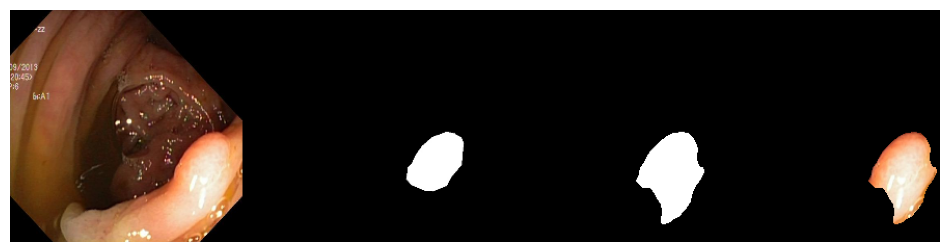

 Epoch: 33 of 100, Iter.: 75 of 75, Train Loss: 0.137565, IoU: 0.905734, Dice: 0.945477
 Epoch: 33 of 100, Iter.: 75 of 75, Valid Loss: 0.561802, IoU: 0.630614, Dice: 0.725737


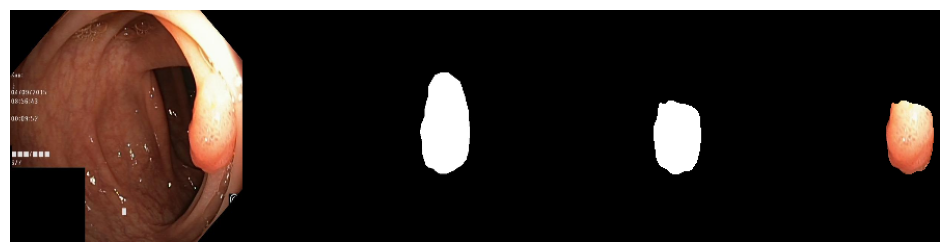

 Epoch: 34 of 100, Iter.: 75 of 75, Train Loss: 0.125098, IoU: 0.914282, Dice: 0.951075
 Epoch: 34 of 100, Iter.: 75 of 75, Valid Loss: 0.596465, IoU: 0.617734, Dice: 0.710430


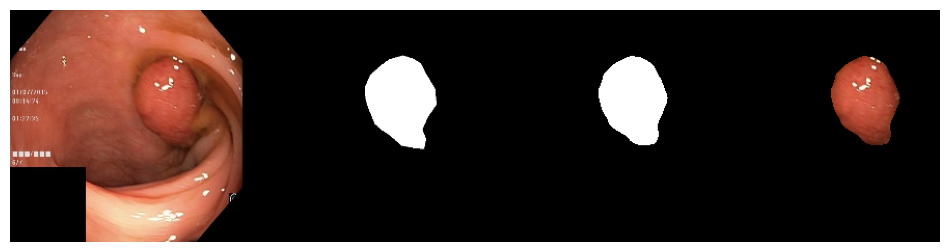

 Epoch: 35 of 100, Iter.: 75 of 75, Train Loss: 0.116440, IoU: 0.923212, Dice: 0.957420
 Epoch: 35 of 100, Iter.: 75 of 75, Valid Loss: 0.585544, IoU: 0.634798, Dice: 0.732729


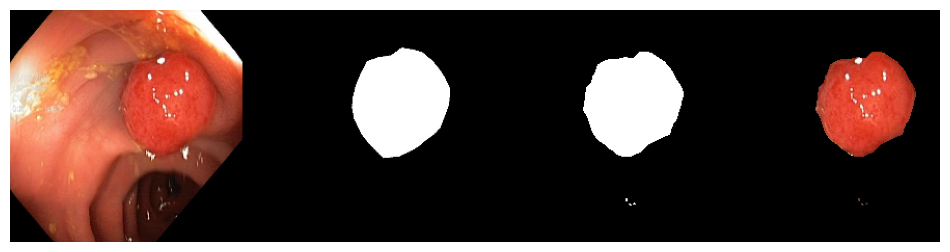

 Epoch: 36 of 100, Iter.: 75 of 75, Train Loss: 0.106411, IoU: 0.925904, Dice: 0.958780
 Epoch: 36 of 100, Iter.: 75 of 75, Valid Loss: 0.565804, IoU: 0.646090, Dice: 0.740342


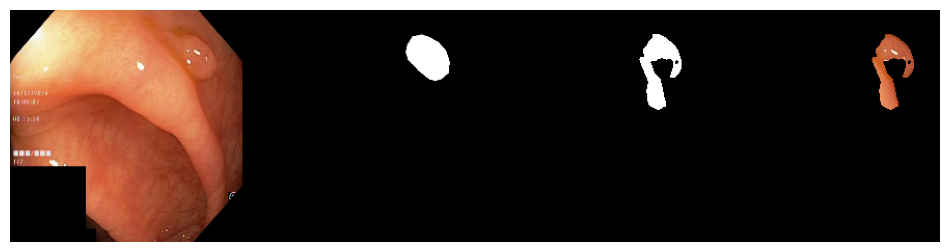

 Epoch: 37 of 100, Iter.: 75 of 75, Train Loss: 0.095370, IoU: 0.937936, Dice: 0.965534
 Epoch: 37 of 100, Iter.: 75 of 75, Valid Loss: 0.549675, IoU: 0.637736, Dice: 0.726809


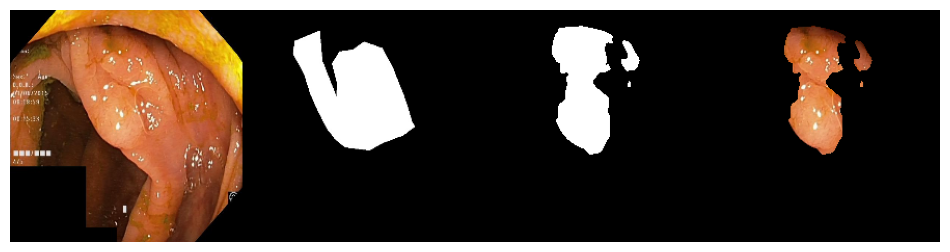

 Epoch: 38 of 100, Iter.: 75 of 75, Train Loss: 0.093312, IoU: 0.939660, Dice: 0.967175
 Epoch: 38 of 100, Iter.: 75 of 75, Valid Loss: 0.524491, IoU: 0.666398, Dice: 0.755713


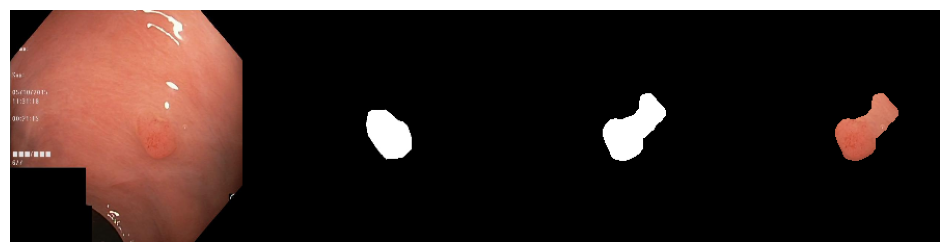

 Epoch: 39 of 100, Iter.: 75 of 75, Train Loss: 0.086316, IoU: 0.943417, Dice: 0.969354
 Epoch: 39 of 100, Iter.: 75 of 75, Valid Loss: 0.544513, IoU: 0.655984, Dice: 0.744832


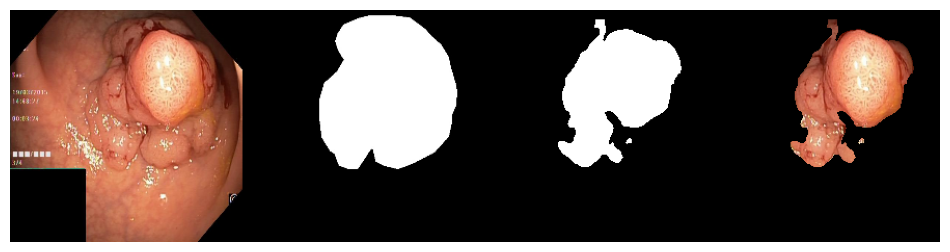

 Epoch: 40 of 100, Iter.: 75 of 75, Train Loss: 0.081823, IoU: 0.946353, Dice: 0.970861
 Epoch: 40 of 100, Iter.: 75 of 75, Valid Loss: 0.542064, IoU: 0.660836, Dice: 0.750666


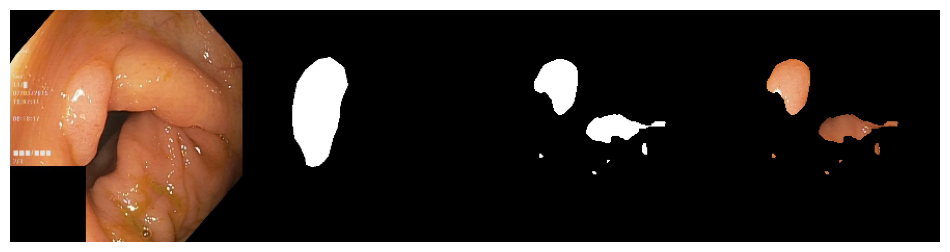

 Epoch: 41 of 100, Iter.: 75 of 75, Train Loss: 0.077367, IoU: 0.947004, Dice: 0.971296
 Epoch: 41 of 100, Iter.: 75 of 75, Valid Loss: 0.553562, IoU: 0.652726, Dice: 0.742953


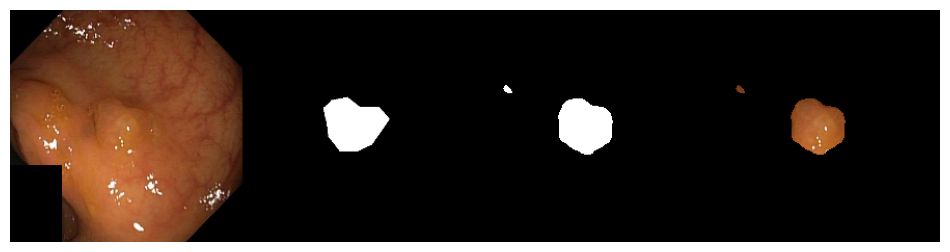

 Epoch: 42 of 100, Iter.: 75 of 75, Train Loss: 0.072551, IoU: 0.948965, Dice: 0.971981
 Epoch: 42 of 100, Iter.: 75 of 75, Valid Loss: 0.545427, IoU: 0.659859, Dice: 0.750141


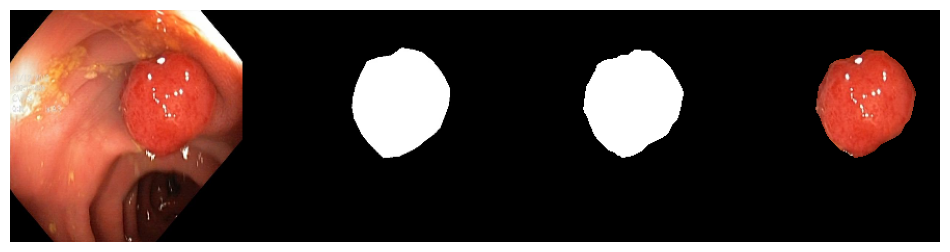

 Epoch: 43 of 100, Iter.: 75 of 75, Train Loss: 0.066178, IoU: 0.953137, Dice: 0.974581
 Epoch: 43 of 100, Iter.: 75 of 75, Valid Loss: 0.554859, IoU: 0.657845, Dice: 0.747305


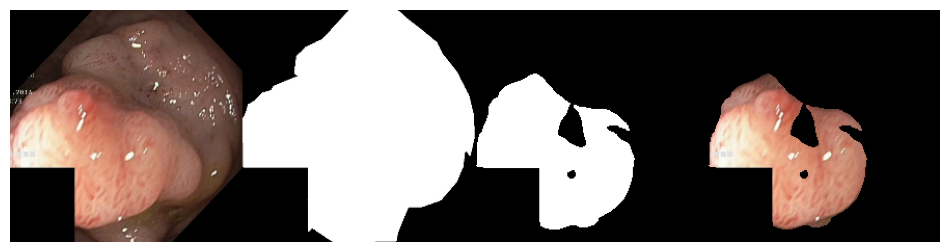

 Epoch: 44 of 100, Iter.: 75 of 75, Train Loss: 0.064515, IoU: 0.954789, Dice: 0.975505
 Epoch: 44 of 100, Iter.: 75 of 75, Valid Loss: 0.548984, IoU: 0.659021, Dice: 0.749285


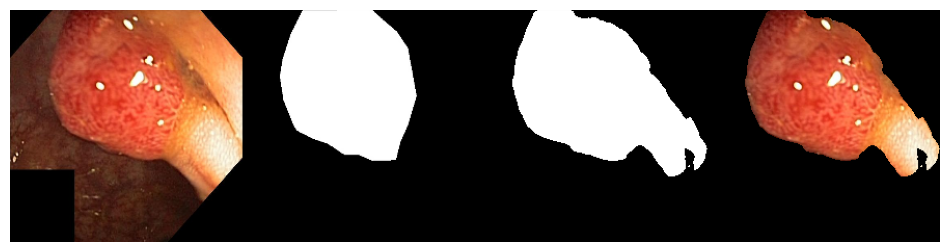

 Epoch: 45 of 100, Iter.: 75 of 75, Train Loss: 0.062163, IoU: 0.954643, Dice: 0.975505
 Epoch: 45 of 100, Iter.: 75 of 75, Valid Loss: 0.554964, IoU: 0.659185, Dice: 0.750288


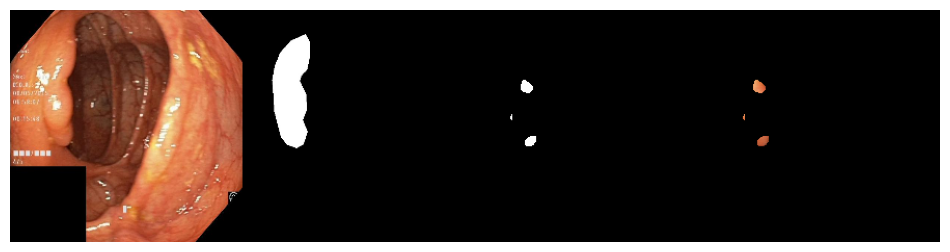

 Epoch: 46 of 100, Iter.: 75 of 75, Train Loss: 0.057930, IoU: 0.956811, Dice: 0.976649
 Epoch: 46 of 100, Iter.: 75 of 75, Valid Loss: 0.582803, IoU: 0.642071, Dice: 0.732718


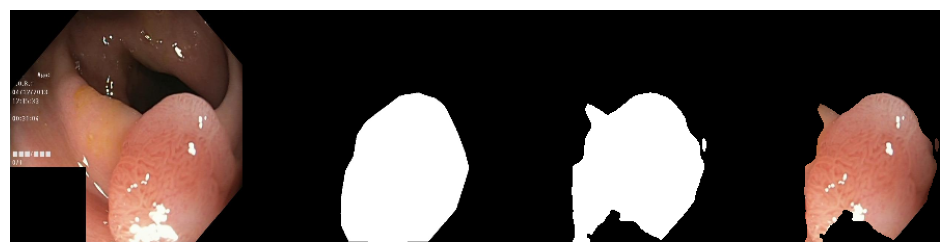

 Epoch: 47 of 100, Iter.: 75 of 75, Train Loss: 0.057111, IoU: 0.956841, Dice: 0.976653
 Epoch: 47 of 100, Iter.: 75 of 75, Valid Loss: 0.566817, IoU: 0.659451, Dice: 0.750035


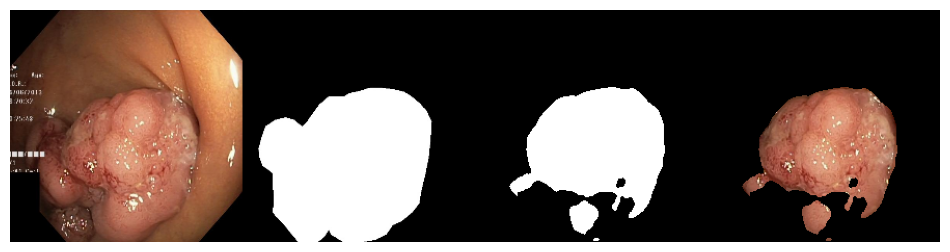

 Epoch: 48 of 100, Iter.: 75 of 75, Train Loss: 0.055078, IoU: 0.957993, Dice: 0.976953
 Epoch: 48 of 100, Iter.: 75 of 75, Valid Loss: 0.561095, IoU: 0.664431, Dice: 0.755751


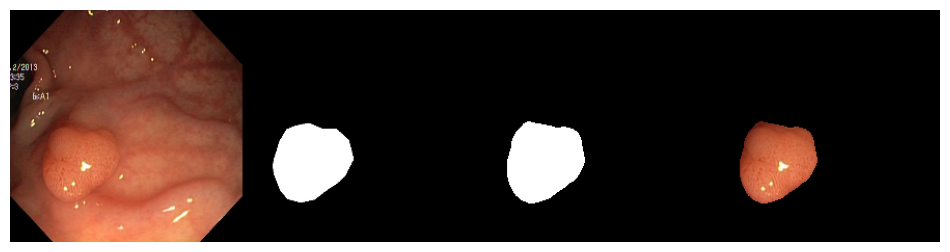

 Epoch: 49 of 100, Iter.: 75 of 75, Train Loss: 0.051483, IoU: 0.959377, Dice: 0.977724
 Epoch: 49 of 100, Iter.: 75 of 75, Valid Loss: 0.581261, IoU: 0.656683, Dice: 0.744227


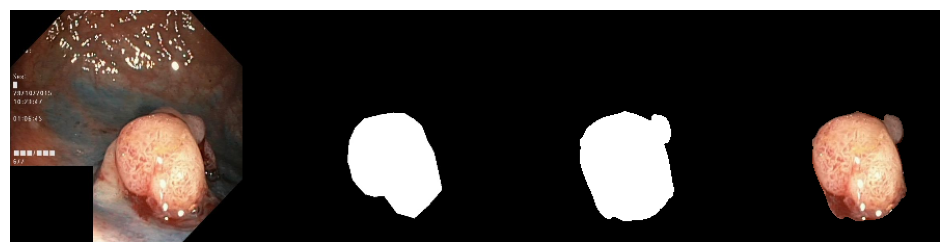

 Epoch: 50 of 100, Iter.: 75 of 75, Train Loss: 0.048778, IoU: 0.961303, Dice: 0.979216
 Epoch: 50 of 100, Iter.: 75 of 75, Valid Loss: 0.557833, IoU: 0.670459, Dice: 0.759281


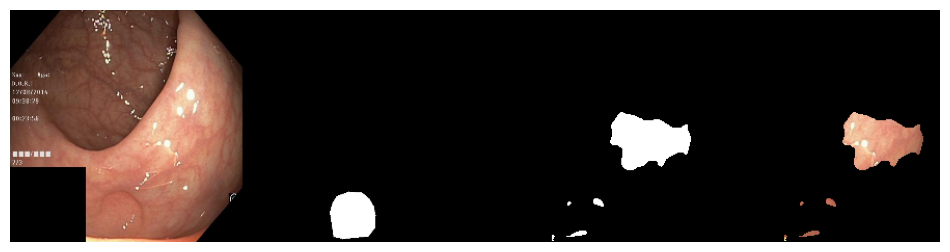

 Epoch: 51 of 100, Iter.: 75 of 75, Train Loss: 0.049492, IoU: 0.959961, Dice: 0.978764
 Epoch: 51 of 100, Iter.: 75 of 75, Valid Loss: 0.752148, IoU: 0.571658, Dice: 0.688312


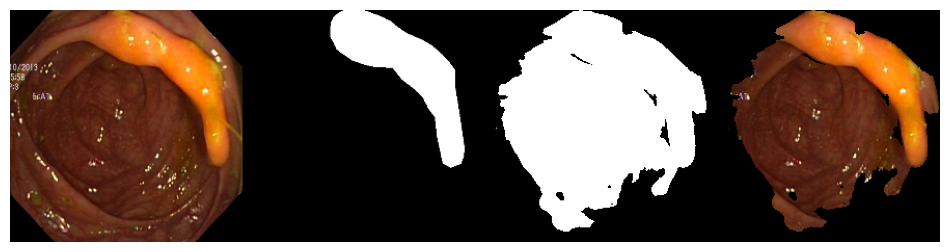

 Epoch: 52 of 100, Iter.: 75 of 75, Train Loss: 0.289265, IoU: 0.765208, Dice: 0.841820
 Epoch: 52 of 100, Iter.: 75 of 75, Valid Loss: 0.857793, IoU: 0.450839, Dice: 0.538614


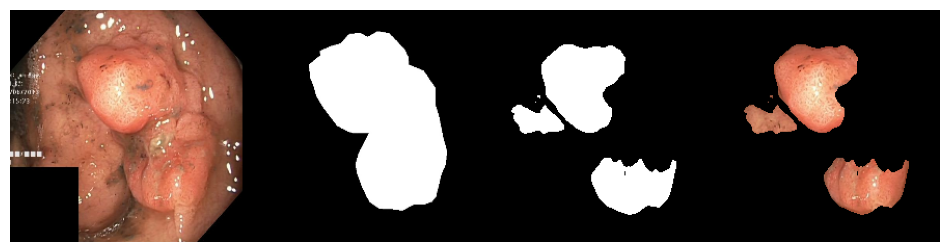

 Epoch: 53 of 100, Iter.: 75 of 75, Train Loss: 0.187619, IoU: 0.823468, Dice: 0.886690
 Epoch: 53 of 100, Iter.: 75 of 75, Valid Loss: 0.634916, IoU: 0.597975, Dice: 0.697089


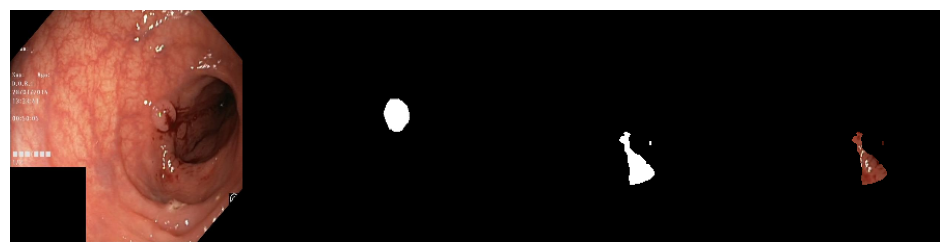

 Epoch: 54 of 100, Iter.: 75 of 75, Train Loss: 0.170107, IoU: 0.844666, Dice: 0.901880
 Epoch: 54 of 100, Iter.: 75 of 75, Valid Loss: 0.551336, IoU: 0.635759, Dice: 0.735586


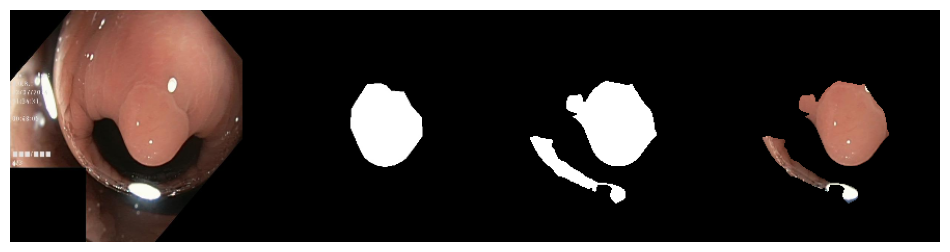

 Epoch: 55 of 100, Iter.: 75 of 75, Train Loss: 0.097324, IoU: 0.905818, Dice: 0.945129
 Epoch: 55 of 100, Iter.: 75 of 75, Valid Loss: 0.596885, IoU: 0.638079, Dice: 0.741418


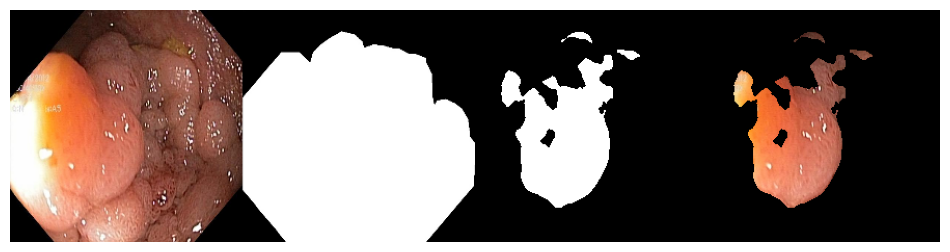

 Epoch: 56 of 100, Iter.: 75 of 75, Train Loss: 0.069547, IoU: 0.929922, Dice: 0.960922
 Epoch: 56 of 100, Iter.: 75 of 75, Valid Loss: 0.577931, IoU: 0.654465, Dice: 0.740465


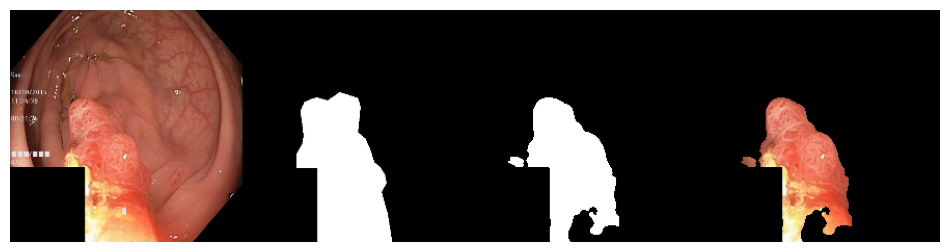

 Epoch: 57 of 100, Iter.: 75 of 75, Train Loss: 0.054402, IoU: 0.947140, Dice: 0.971086
 Epoch: 57 of 100, Iter.: 75 of 75, Valid Loss: 0.560256, IoU: 0.661177, Dice: 0.751058


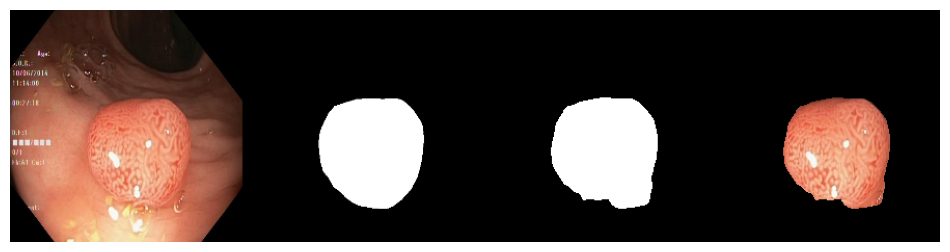

 Epoch: 58 of 100, Iter.: 75 of 75, Train Loss: 0.048895, IoU: 0.954579, Dice: 0.975828
 Epoch: 58 of 100, Iter.: 75 of 75, Valid Loss: 0.581367, IoU: 0.658356, Dice: 0.746487


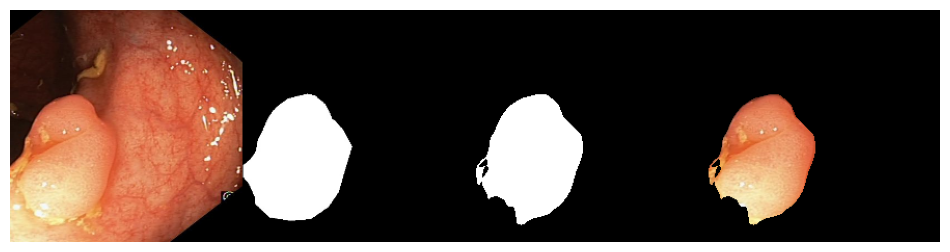

 Epoch: 59 of 100, Iter.: 75 of 75, Train Loss: 0.043503, IoU: 0.960187, Dice: 0.978945
 Epoch: 59 of 100, Iter.: 75 of 75, Valid Loss: 0.611892, IoU: 0.641017, Dice: 0.729753


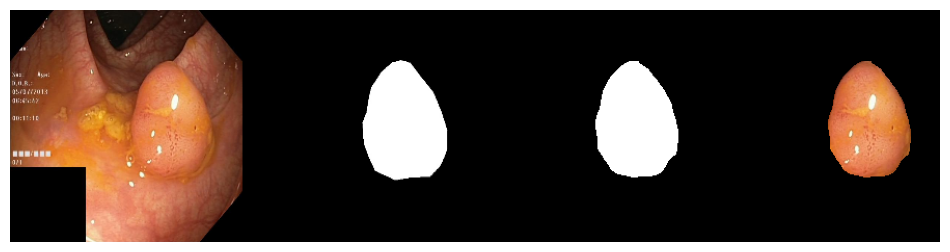

 Epoch: 60 of 100, Iter.: 75 of 75, Train Loss: 0.041441, IoU: 0.962313, Dice: 0.979800
 Epoch: 60 of 100, Iter.: 75 of 75, Valid Loss: 0.576924, IoU: 0.669311, Dice: 0.758867


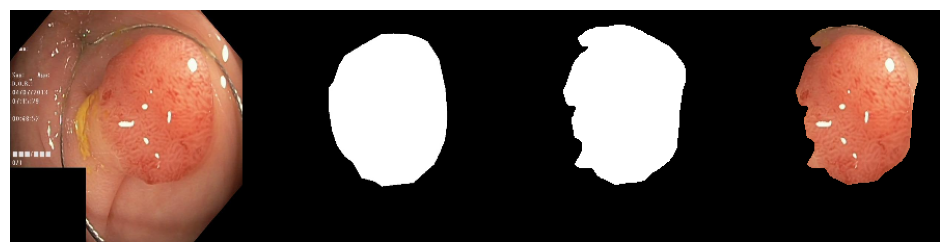

 Epoch: 61 of 100, Iter.: 75 of 75, Train Loss: 0.038864, IoU: 0.963467, Dice: 0.980660
 Epoch: 61 of 100, Iter.: 75 of 75, Valid Loss: 0.593558, IoU: 0.658255, Dice: 0.746630


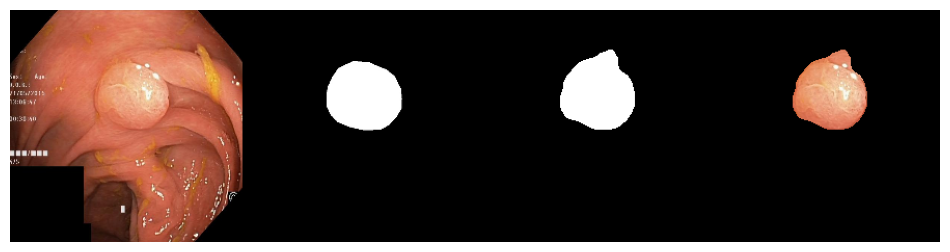

 Epoch: 62 of 100, Iter.: 75 of 75, Dice: 0.981810, Val. Dice: 0.634390ce:  0.981810

[ WARN:0@1578.917] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/data/segmentation/segmentation/Kvasir-SEG/validationset/images/image_422.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1578.975] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/data/segmentation/segmentation/Kvasir-SEG/validationset/images/image_433.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1579.065] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/data/segmentation/segmentation/Kvasir-SEG/validationset/images/image_482.jpg'): can't open/read file: check file path/integrity


 Epoch: 62 of 100, Iter.: 75 of 75, Dice: 0.981810, Val. Dice: 0.715641

[ WARN:0@1579.160] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/data/segmentation/segmentation/Kvasir-SEG/validationset/images/image_510.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1579.245] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/data/segmentation/segmentation/Kvasir-SEG/validationset/images/image_536.jpg'): can't open/read file: check file path/integrity


error: Caught error in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/project/segmentation/smcho1201/segmentation_project/utils/dataset.py", line 39, in __getitem__
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # cv2는 채널이 BGR로 저장된다 -> 출력할 때 RGB로 바꿔줘야함
cv2.error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



In [12]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:50, Best_IOU:0.6705, Best_DiceScore:0.7593


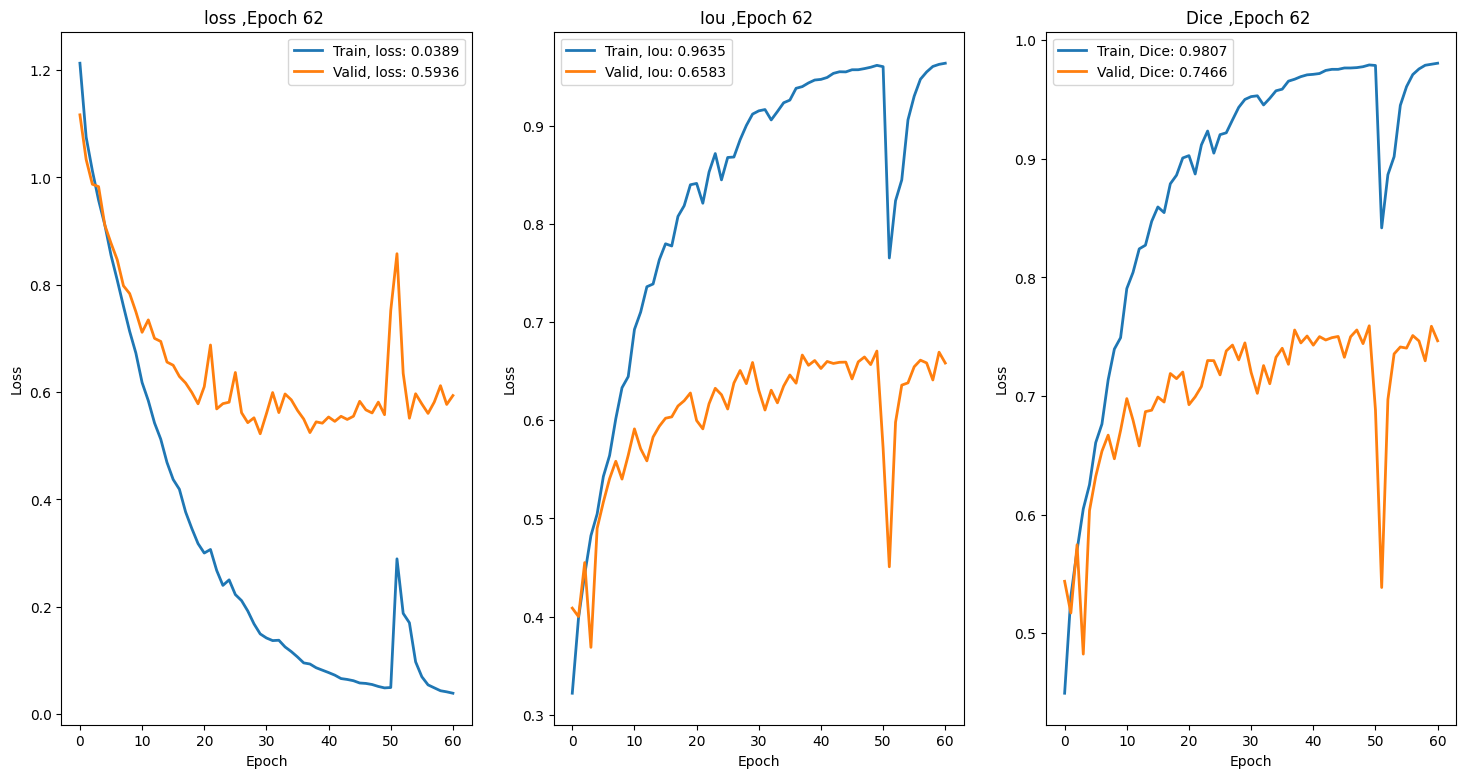

In [13]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()